<a href="https://colab.research.google.com/github/jailsonpj/master-project/blob/main/exp1_contrastive_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Network - Contrastive Loss

## SetUp Libs


In [1]:
!pip install -q transformers

In [2]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Class Dataset

- Class Article Dataset
- Class Custom Dataset

In [3]:
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# read csv datasets
import pandas as pd
import numpy as np

class NewsPaperData:
    def __init__(self, path):
        self.path = path
        self.list_filenames = ["news-aggregator.csv", "news-february.csv", "news-july.csv"]
        self.df_list = list()

    def read_file(self, filename):
        return pd.read_csv(self.path + filename)

    def union_title_corpus(self, df, column_title, column_corpus):
        df["text"] = df[[column_title, column_corpus]].apply(
            lambda x: str(x[0]) + " " + str(x[1]), axis=1
        )
        return df
    
    def df_label_encoded(self, df, column_label):
        df = df.query(f"`{column_label}` == 'left' or `{column_label}` == 'right'")
        df[column_label] = pd.Categorical(df[column_label])
        df[column_label] = df[column_label].cat.codes
        return df.reset_index(drop=True)

    def drop_return(self, df, index):
        row = df.loc[index]
        df.drop(index, inplace=True)
        return row, df

    def df_partition_label(self, df, column_label):
        df_left = df.query(f"`{column_label}` == 0").reset_index(drop=True)
        df_right = df.query(f"`{column_label}` == 1").reset_index(drop=True)

        MAX = len(df_left) if len(df_left) < len(df_right) else len(df_right)
        df_left, df_right = df_left[:MAX], df_right[:MAX]
        df_all = pd.DataFrame(columns=df.columns)

        for idx in range(0, MAX):
            row_left, df_left = self.drop_return(df_left, idx)
            row_right, df_right = self.drop_return(df_right, idx)
            df_all = df_all.append(row_left.to_dict(), ignore_index=True)
            df_all = df_all.append(row_right.to_dict(), ignore_index=True)

        return df_all

    def rename_columns(self, df, dict_map):
        return df.rename(columns=dict_map)

    def get_dataset_custom(self):
        dict_map = {"Bias": "labels"}

        for filename in self.list_filenames:
            self.df_list.append(
                self.read_file(filename)
            )

        df = pd.concat(self.df_list, ignore_index=True)
        df = self.union_title_corpus(df, "Title", "Content")
        df = self.df_label_encoded(df, "Bias")
        df = self.rename_columns(df, dict_map)

        return df

In [6]:
dataset = NewsPaperData("/content/drive/MyDrive/mestrado/src/")
df = dataset.get_dataset_custom()

In [7]:
df[:1000]

,Source,Title,Content,labels,text
0,cnn.com,Stocks slip slightly,With little U.S. economic or corporate news on...,0,Stocks slip slightly With little U.S. economic...
1,investors.com,Stocks Down At Midday On Weak China Export Data,Stocks were down across the board at midday Mo...,1,Stocks Down At Midday On Weak China Export Dat...
2,cnn.com,Winners and losers of the bull market,It's been five years since the stock market hi...,0,Winners and losers of the bull market It's bee...
3,foxnews.com,Does Mt. Gox CEO still control all those stole...,next Image 1 of 3 prev next Image 2 of 3 prev ...,1,Does Mt. Gox CEO still control all those stole...
4,mashable.com,Bankrupt Exchange Mt. Gox Still Has $600 Milli...,Japan-based Bitcoin exchange Mt.Gox has been d...,0,Bankrupt Exchange Mt. Gox Still Has $600 Milli...
...,...,...,...,...,...
995,whitehousewatch.com,Dan Froomkin's White House Watch Disaster and...,"Over the past several years, a considerable nu...",0,Dan Froomkin's White House Watch Disaster and...
996,whitehousewatch.com,Give up on getting this White House to answer ...,Its time to declare press relations with this ...,0,Give up on getting this White House to answer ...
997,whitehousewatch.com,The death of Jamal Khashoggi reveals a univers...,Reports from Turkish sources suggest that diss...,0,The death of Jamal Khashoggi reveals a univers...
998,whitehousewatch.com,Can a president keep official actions secret e...,Donald Trumps unprecedented and deeply suspici...,0,Can a president keep official actions secret e...


In [8]:
from transformers import BertTokenizer, BertModel, BertConfig
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.article_text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.article_text)

    def __getitem__(self, index):
        article_text = str(self.article_text[index])
        article_text = " ".join(article_text.split())

        inputs = self.tokenizer.encode_plus(
            article_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [9]:
df_train = df[:1000].reset_index()
df_val = df[1000:2000].reset_index()
df_test = df[2000:3000].reset_index()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

training_set = CustomDataset(df_train, tokenizer, 512)
validating_set = CustomDataset(df_val, tokenizer, 512)
testing_set = CustomDataset(df_test, tokenizer, 512)

In [10]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validating_loader = DataLoader(validating_set, **test_params)
testing_loader = DataLoader(testing_set, **test_params)

## SetUP Loss

In [11]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers

In [12]:
### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
loss_func = losses.ContrastiveLoss(pos_margin=0, neg_margin=1)#, distance=distance)

## Class Network
- Class BERTClass

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import BertTokenizer, BertModel, BertConfig

# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
  def __init__(self):
    super(BERTClass, self).__init__()
    self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
    self.l3 = torch.nn.Linear(768, 256)
  
  def forward(self, ids, mask, token_type_ids):
    _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
    output = self.l3(output_1)
    return output
    
  def get_embedding(self, ids, mask, token_type_ids):
    return self.forward(ids, mask, token_type_ids)

In [14]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

## Train Model
- Train

- Test

- fit

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss(num_epochs, train_loss, val_loss):
  plt.plot(range(0, num_epochs), train_loss, "-b", label="train-loss")
  plt.plot(range(0, num_epochs), val_loss, "-r", label="val-loss")
  plt.xlabel("Epochs Iteration")
  plt.legend(loc="upper left")
  plt.title("Loss Train and Validate")
  plt.savefig("Loss_Validate.png")
  plt.show()

In [16]:
def train(model, loss_func, device, train_loader, optimizer):
  model.train()
  losses = []
  total_loss = 0

  for batch_idx, data in enumerate(train_loader):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)

    optimizer.zero_grad()
    embeddings = model(ids, mask, token_type_ids)

    loss = loss_func(embeddings, targets)
    losses.append(loss.item())
    total_loss += loss.item()
    loss.backward()

    optimizer.step()
    if batch_idx % 20 == 0:
      message = "Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
          batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), np.mean(losses)
      )
      print(message)
      losses = []

    total_loss /= (batch_idx + 1)
    return total_loss

In [17]:
def test(model, loss_func, device, val_loader):
  with torch.no_grad():
    model.eval()
    val_loss = 0
    for batch_idx, data in enumerate(val_loader):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      embeddings = model(ids, mask, token_type_ids)
      loss_outputs = loss_func(embeddings, targets)

      loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
      val_loss += loss.item()

    return val_loss


In [18]:
def fit(train_loader, val_loader, model, loss_func, optimizer, scheduler, num_epochs, device, start_epoch=0):
  for epoch in range(0, start_epoch):
    scheduler.step()

  train_plot, val_plot = [], []
  for epoch in range(start_epoch, num_epochs):
    scheduler.step()

    # Train stage
    train_loss = train(model, loss_func, device, train_loader, optimizer)
    train_plot.append(train_loss)

    message = "Epoch: {}/{}. Train set: Average Loss: {:.4f}".format(epoch + 1, num_epochs, train_loss)

    # Validation Stage
    val_loss = test(model, loss_func, device, val_loader)
    val_loss /= len(val_loader)
    val_plot.append(val_loss)
    message += "\nEpoch: {}/{}. Validation set: Average Loss: {:.4f}".format(epoch + 1, num_epochs,
                                                                             val_loss)
    print(message)
    
  plot_loss(num_epochs, train_plot, val_plot)

In [19]:
from torch.optim import lr_scheduler
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
num_epochs = 100

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train: [0/1000 (0%)]	Loss: 0.997361
Epoch: 1/100. Train set: Average Loss: 0.9974
Epoch: 1/100. Validation set: Average Loss: 0.8956
Train: [0/1000 (0%)]	Loss: 1.039141
Epoch: 2/100. Train set: Average Loss: 1.0391
Epoch: 2/100. Validation set: Average Loss: 0.8200
Train: [0/1000 (0%)]	Loss: 1.004831
Epoch: 3/100. Train set: Average Loss: 1.0048
Epoch: 3/100. Validation set: Average Loss: 0.8640
Train: [0/1000 (0%)]	Loss: 1.009088
Epoch: 4/100. Train set: Average Loss: 1.0091
Epoch: 4/100. Validation set: Average Loss: 0.8680
Train: [0/1000 (0%)]	Loss: 1.000480
Epoch: 5/100. Train set: Average Loss: 1.0005
Epoch: 5/100. Validation set: Average Loss: 0.8440
Train: [0/1000 (0%)]	Loss: 1.002179
Epoch: 6/100. Train set: Average Loss: 1.0022
Epoch: 6/100. Validation set: Average Loss: 0.9040
Train: [0/1000 (0%)]	Loss: 1.000782
Epoch: 7/100. Train set: Average Loss: 1.0008
Epoch: 7/100. Validation set: Average Loss: 0.8880
Train: [0/1000 (0%)]	Loss: 1.000376
Epoch: 8/100. Train set: Average 

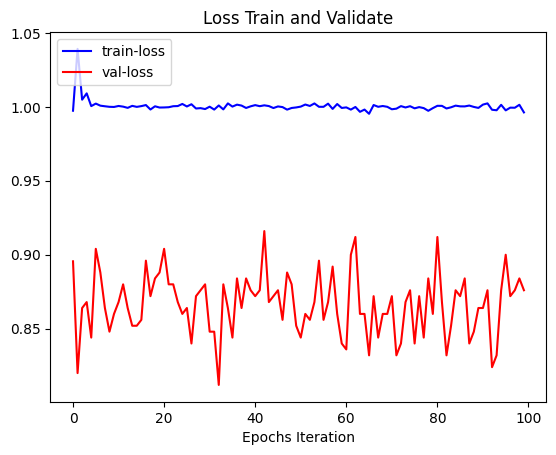

In [20]:
fit(training_loader, validating_loader, model, loss_func, optimizer, scheduler, num_epochs, device)

## Validation Model

In [21]:
def extract_embeddings(dataloader, model):
  with torch.no_grad():
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 256))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for batch_idx, data in enumerate(dataloader):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      embeddings[k:k+len(data)] = model.get_embedding(ids, mask, token_type_ids).data.cpu().numpy()
      labels[k:k+len(data)] = targets.data.cpu().numpy()
      k += len(data)

  return embeddings, labels


In [22]:
testing_embeddings_cl, testing_labels_cl = extract_embeddings(testing_loader, model)

In [23]:
# Save test embeddings for visualization in projector
import io
np.savetxt("vecs.tsv", testing_embeddings_cl, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
[out_m.write(str(x) + "\n") for x in testing_labels_cl]
out_m.close()

### Model CLassification
- Logistic Regression
- Decision Tree

In [24]:
def train_model(model, X, y):
  clf = model.fit(X, y)
  return clf

def predict_model(clf, X):
  return clf.predict(X)

In [25]:
# Logistic
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

clf = LogisticRegression(random_state=0)
clf_trained = train_model(clf, testing_embeddings_cl[:500], testing_labels_cl[:500])
predicts_result = predict_model(clf_trained, testing_embeddings_cl[500:])

print("Accuracy Logistic Regression: ", accuracy_score(testing_labels_cl[500:], predicts_result))
print("-------------------------------")
print("F1 Score Logistic Regression: ", f1_score(testing_labels_cl[500:], predicts_result))
print("-------------------------------")
print("Confusion Matrix Logistic Regression\n: ", confusion_matrix(testing_labels_cl[500:], predicts_result))

Accuracy Logistic Regression:  0.628
-------------------------------
F1 Score Logistic Regression:  0.7714987714987714
-------------------------------
Confusion Matrix Logistic Regression
:  [[  0 186]
 [  0 314]]


In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

result_cross = cross_val_score(clf, testing_embeddings_cl[:500], testing_labels_cl[:500], cv=10)

clf_trained = train_model(clf, testing_embeddings_cl[:500], testing_labels_cl[:500])
predicts_result = predict_model(clf_trained, testing_embeddings_cl[500:])

print("Cross Validation: ", result_cross)
print("Accuracy Decision Tree: ", accuracy_score(testing_labels_cl[500:], predicts_result))
print("-------------------------------")
print("F1 Score Decision Tree: ", f1_score(testing_labels_cl[500:], predicts_result))
print("-------------------------------")
print("Confusion Matrix Decision Tree\n: ", confusion_matrix(testing_labels_cl[500:], predicts_result))

Cross Validation:  [0.54 0.4  0.52 0.6  0.64 0.48 0.48 0.56 0.6  0.6 ]
Accuracy Logistic Regression:  0.568
-------------------------------
F1 Score Logistic Regression:  0.6737160120845921
-------------------------------
Confusion Matrix Logistic Regression
:  [[ 61 125]
 [ 91 223]]
